# ***Final Assignment - Applied ML***
**<u>By:</u> Omer Shadmi (327722575), Shira Lavi (216006395) & Emily Bederov (215025255)**


--------

## **Preperations**

In [2]:
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

### <u>Reading the Dataset:</u>

Due to time and computational resources limitations, we will be working with a smaller version of the dataset, containing only the first 100k rows.

In [37]:
path_to_data = "review_230k.parquet"
data = pd.read_parquet(path_to_data)

# Keep only the first 100k rows
shorten_data = data.head(100000)

In [ ]:
# Print the shape of the new dataset to verify
print(f"Shape of shorten_data: {shorten_data.shape}")

Shape of shorten_data: (100000, 2)


In [ ]:
shorten_data.head(3)

,title,text
0,"Truly is ""Jewel of the Upper Wets Side""",Stayed in a king suite for 11 nights and yes i...
1,My home away from home!,"On every visit to NYC, the Hotel Beacon is the..."
2,Great Stay,This is a great property in Midtown. We two di...


We create a function to combine the title and text columns, and convert them to lowercase.

In [38]:
def create_dataset(data: pd.DataFrame) -> pd.Series:
    """Create the dataset in your preferable format"""
    # Combine title and text, and convert to lowercase
    return data['title'].str.lower() + ' ' + data['text'].str.lower()

In [39]:
dataset = create_dataset(shorten_data)

In [ ]:
dataset.head(3)

0    truly is "jewel of the upper wets side" stayed...
1    my home away from home! on every visit to nyc,...
2    great stay this is a great property in midtown...
dtype: object

### <u>Cleaning the Dataset:</u>


In [40]:
import re

This function removes special characters and digits, and removes extra whitespace.

In [41]:
def prepare_dataset(dataset: pd.Series) -> pd.Series:
    """Clean and prepare the dataset before word encoding"""

    def clean_text(text: str) -> str:
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    return dataset.apply(clean_text)

dataset = prepare_dataset(dataset)

And now we can see the cleaned dataset:

In [ ]:
dataset.head(3)

0    truly is jewel of the upper wets side stayed i...
1    my home away from home on every visit to nyc t...
2    great stay this is a great property in midtown...
dtype: object

----------------

## **Encoding the Dataset**


### <u>Create Vocabulary:</u>


In [42]:
from collections import Counter

A frequency dictionary is created to map each word to its respective frequency.


In [43]:
# Create freq_before_subsampling dictionary
def create_vocabulary(dataset: pd.Series) -> dict:
    """Create a dictionary mapping each word to its respective frequency"""
    words = ' '.join(dataset).split()
    return dict(Counter(words))

freq_voc = create_vocabulary(dataset)

We subsample words of two types:
1. Frequent words, with a probability of being subsampled proportional to their frequency.
2. Rare words, with less than 10 occurrences.

The formula for subsampling frequent words is:

$P(w) = \left(\sqrt{\frac{z(w)}{0.001}} + 1\right) \cdot \frac{0.001}{z(w)}$

Where z(w) is the fraction of the total words in the corpus that are
that word.


In [44]:
# Set a fixed seed for reproducibility
np.random.seed(42)

# Calculate total number of words
total_words = sum(freq_voc.values())

# The fraction of the word's frequency over the total number of words
def z(word):
    return freq_voc[word] / total_words

# The probability of subsampling the word
def p(word):
    z_w = z(word)
    return (((z_w / 0.001) ** 0.5) + 1) * (0.001 / z_w)

# Create a copy of the dictionary to iterate over
words_to_check = list(freq_voc.keys())

for word in words_to_check:
    freq = freq_voc[word]
    # Remove frequent words based on subsampling probability
    if np.random.random() > p(word):
        del freq_voc[word]
    # Remove rare words (less than 10 occurrences)
    elif freq < 10:
        del freq_voc[word]

In [ ]:
# Print statistics
initial_vocab_size = len(words_to_check)
final_vocab_size = len(freq_voc)
removed_words = initial_vocab_size - final_vocab_size

print(f"Initial vocabulary size: {initial_vocab_size}")
print(f"Total words removed: {removed_words}")
print(f"Final vocabulary size: {final_vocab_size}")

Initial vocabulary size: 167438
Total words removed: 144723
Final vocabulary size: 22715


In [ ]:
# Print some examples
print("\nSome examples from the vocabulary:")
for word, freq in list(freq_voc.items())[:3]:
    print(f"{word}: {freq}")


Some examples from the vocabulary:
truly: 1281
jewel: 125
upper: 2218


### <u>Word Encoding:</u>


Before encoding, we need to determine the optimal sequence length.
As we can see, length of 200 is enough to capture most of the reviews.


In [ ]:
lengths = dataset.apply(lambda x: len(x.split()))
percentage_captured = (lengths <= 200).mean() * 100

print(f"Percentage of reviews fully captured with length 200: {percentage_captured:.2f}%")

Percentage of reviews fully captured with length 200: 80.78%


In [ ]:
from tensorflow.keras.layers import TextVectorization

This function encodes the dataset using the vocabulary created above, and returns the encoded dataset, the encoding vocabulary, and the inverse vocabulary.


In [ ]:
def encode_dataset(dataset: pd.Series, freq_voc: Dict[str, int]) -> Tuple[List[np.ndarray], List[str], Dict[int, str]]:
    """
    Encode each word in the dataset, based on your vocabulary
    :param: dataset: A pandas Series containing the text data to be encoded
    :param: freq_voc: A dictionary containing word frequencies, used as the vocabulary
    :return: the encoded dataset, the encoding vocabulary, and the inverse vocabulary
    """
    # Convert the dataset to a tf.data.Dataset
    text_ds = tf.data.Dataset.from_tensor_slices(dataset.values)

    # Define the TextVectorization layer
    max_tokens = len(freq_voc) + 2  # +2 for padding and unknown tokens
    sequence_length = 200

    vectorize_layer = TextVectorization(
        max_tokens=max_tokens,
        output_mode='int',
        output_sequence_length=sequence_length,
        vocabulary=list(freq_voc.keys())
    )

    # Get the vocabulary from the layer
    encoding_vocabulary = vectorize_layer.get_vocabulary()

    # Create the inverse vocabulary (index to word mapping)
    inverse_vocabulary = dict(enumerate(encoding_vocabulary))

    # Apply the vectorization to the dataset
    encoded_ds = text_ds.map(vectorize_layer)

    # Convert to a list of numpy arrays
    encoded_dataset = list(encoded_ds.as_numpy_iterator())

    return encoded_dataset, encoding_vocabulary, inverse_vocabulary

# Use the function to encode the dataset and get vocabularies
encoded_dataset, encoding_vocabulary, inverse_vocabulary = encode_dataset(dataset, freq_voc)

Example of the encoding process:

In [ ]:
# Get the first row of the dataset
example_sentence = dataset.iloc[0]

# Split the sentence into words and take the first 10
original_words = example_sentence.split()[:10]

# Get the corresponding encoded values
encoded_values = encoded_dataset[0][:10]

print("\nFirst 10 words of the first sentence:")
for original, encoded in zip(original_words, encoded_values):
    print(f"'{original}' -> {encoded} ({encoding_vocabulary[encoded]})")


First 10 words of the first sentence:
'truly' -> 2 (truly)
'is' -> 1 ([UNK])
'jewel' -> 3 (jewel)
'of' -> 1 ([UNK])
'the' -> 1 ([UNK])
'upper' -> 4 (upper)
'wets' -> 1 ([UNK])
'side' -> 5 (side)
'stayed' -> 6 (stayed)
'in' -> 1 ([UNK])


-------

## **Positive Pairs and Negative Samples**


In [ ]:
from tqdm import tqdm

We used more efficient types for the targets, contexts, and labels, in order to save memory. We need to cast them back to int32 when we use them in the model.

In [ ]:
def generate_training_data(
    sequences: List[np.ndarray],
    window_size: int,
    num_ns: int,
    vocab_size: int,
    seed: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate skip-gram pairs with negative sampling for a list of sequences.

    :param sequences: List of int-encoded sentences
    :param window_size: Size of the window for positive context words
    :param num_ns: Number of negative samples per positive context
    :param vocab_size: Size of the vocabulary
    :param seed: Random seed for reproducibility
    :return: Numpy arrays of targets, contexts, and labels
    """
    targets, contexts, labels = [], [], []

    # Use np.uint16 for final numpy arrays
    dtype = np.uint16

    # Build the sampling table for `vocab_size` tokens
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in the dataset
    for sequence in tqdm(sequences):
        # Generate positive skip-gram pairs for a sequence
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            negative_samples=0)

        # Iterate over each positive skip-gram pair to produce training examples
        for target_word, context_word in positive_skip_grams:
            context_class = tf.constant([context_word], dtype="int64")
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=tf.expand_dims(context_class, 1),
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size,
                seed=seed,
                name="negative_sampling")

            # Build context and label vectors (for one target word)
            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0] * num_ns, dtype="int64")

            # Append each element from the training example to global lists
            targets.append(target_word)
            contexts.append(context.numpy())
            labels.append(label.numpy())

    return np.array(targets, dtype=dtype), np.array(contexts, dtype=dtype), np.array(labels, dtype=np.int8)

We choose the following parameters:


In [16]:
# For our usage
WINDOW_SIZE = 2
NEGATIVE_SAMPLES = 4
SEED = 42
vocab_size = len(encoding_vocabulary)

In [ ]:
vocab_size

22717

In [ ]:
# Generate training data
targets, contexts, labels = generate_training_data(
    sequences=encoded_dataset,
    window_size=WINDOW_SIZE,
    num_ns=NEGATIVE_SAMPLES,
    vocab_size=vocab_size,
    seed=SEED
)

100%|██████████| 100000/100000 [47:28<00:00, 35.10it/s]


In [ ]:
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")



targets.shape: (9826613,)
contexts.shape: (9826613, 5)
labels.shape: (9826613, 5)


-------

## **Model Definition**


In [4]:
from tensorflow.keras import Model, layers, Input

In [5]:
def create_word2vec_model(vocab_size: int, embedding_dim: int) -> Model:
    # Input layers
    target_input = Input(shape=(), dtype=tf.int32, name='target_input')
    context_input = Input(shape=(None,), dtype=tf.int32, name='context_input')

    # Embedding layers
    target_embedding = layers.Embedding(vocab_size, embedding_dim, name="w2v_embedding")(target_input)
    context_embedding = layers.Embedding(vocab_size, embedding_dim, name="context_embedding")(context_input)

    # Compute dot product
    dots = layers.Dot(axes=(1, 2))([target_embedding, context_embedding])

    # Create and return the model
    model = Model(inputs=[target_input, context_input], outputs=dots)
    return model

In [8]:
# Define model parameters
vocab_size = len(encoding_vocabulary)
embedding_dim = 50

In [10]:
# Instantiate the model
model = create_word2vec_model(vocab_size, embedding_dim)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

------

## **Training The Model**

### <u>Training:</u>

In [13]:
# Define constants
EPOCHS = 10
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
AUTOTUNE = tf.data.AUTOTUNE

# Function to cast the types
def cast_types(x, y):
    return (tf.cast(x[0], tf.int32), tf.cast(x[1], tf.int32)), tf.cast(y, tf.float32)

# Create the dataset from our targets, contexts, and labels
training_data = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))

# Apply type casting
training_data = training_data.map(cast_types, num_parallel_calls=AUTOTUNE)

# Shuffle and batch the dataset
training_data = training_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Cache and prefetch for better performance
training_data = training_data.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
print(training_data)

<_PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int32, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int32, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.float32, name=None))>


In [17]:
# Set up callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="model_logs")

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"word2vec_model_w{WINDOW_SIZE}_ns{NEGATIVE_SAMPLES}_ckpt.keras",
    monitor='loss',
    save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True,
    monitor='accuracy'
)

In [18]:
# Train the model
history = model.fit(training_data, epochs=EPOCHS)

# Save the final model
model.save(f"word2vec_model_w{WINDOW_SIZE}_ns{NEGATIVE_SAMPLES}.keras", include_optimizer=True)

print("Model saved successfully!")

Epoch 1/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 620s 64ms/step - accuracy: 0.6809 - loss: 0.3628
Epoch 2/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 217s 23ms/step - accuracy: 0.7865 - loss: 0.2643
Epoch 3/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 220s 23ms/step - accuracy: 0.8057 - loss: 0.2500
Epoch 4/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 215s 22ms/step - accuracy: 0.8143 - loss: 0.2433
Epoch 5/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 216s 23ms/step - accuracy: 0.8195 - loss: 0.2392
Epoch 6/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 220s 23ms/step - accuracy: 0.8229 - loss: 0.2362
Epoch 7/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 262s 23ms/step - accuracy: 0.8255 - loss: 0.2340
Epoch 8/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 212s 22ms/step - accuracy: 0.8275 - loss: 0.2322
Epoch 9/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 206s 21ms/step - accuracy: 0.8291 - loss: 0.2308
Epoch 10/10
9596/9596 ━━━━━━━━━━━━━━━━━━━━ 277s 23ms/step - accuracy: 0.8304 - loss: 0.2296
Model saved successfully!


### <u>Save the Embeddings:</u>


In [ ]:
# Print the first 10 values of encoding_vocabulary
print("First 10 items in encoding_vocabulary:")
for item in encoding_vocabulary[:10]:
    print(item)

First 10 items in encoding_vocabulary:

[UNK]
truly
jewel
upper
side
stayed
a
king
suite


As we can see, the first word in the vocabulary is "<pad>" - padding token, so we will start from the second word, when saving the embeddings.


In [4]:
import pyarrow as pa
import pyarrow.parquet as pq

In [20]:
def save_embeddings(model: tf.keras.Model, vocabulary: List[str], path: str) -> None:
    """
    Save the embeddings
    param: model: the trained tf model
    param: vocabulary: list of tokens
    param: path: the path to save the embeddings map
    """
    # Get the embeddings from the model
    embeddings = model.get_layer("w2v_embedding").get_weights()[0]

    # Create a dictionary to store the embeddings
    embedding_dict = {}

    # Iterate through the vocabulary and embeddings, starting from index 1
    for word, embed in zip(vocabulary[1:], embeddings[1:]):
        embedding_dict[word] = embed

    # Convert the dictionary to a pandas DataFrame
    df = pd.DataFrame.from_dict(embedding_dict, orient='index')

    # Convert the pandas DataFrame to a PyArrow Table
    table = pa.Table.from_pandas(df)

    # Write the PyArrow Table to a Parquet file
    pq.write_table(table, path)

    print(f"Embeddings saved successfully to {path}")

In [21]:
# For our usage
save_embeddings(model, encoding_vocabulary, "word2vec_embeddings_os.parquet")

Embeddings saved successfully to word2vec_embeddings_os.parquet


--------

## **Find Most Similar - Show Time!**


### Run this cell first:


In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from scipy.spatial.distance import cosine

# Load embeddings outside the function
table = pq.read_table("word2vec_embeddings_os.parquet")
embeddings = table.to_pandas()

# Pre-compute norms for all embeddings
norms = np.linalg.norm(embeddings.values, axis=1)

def find_most_similar(word: str, k: int = 10) -> pd.DataFrame:
    """
    Find most similar tokens to word
    param: word: the word to find most similar words to
    k: number of most similar words
    """
    # Check if the word is in the vocabulary
    if word not in embeddings.index:
        return pd.DataFrame({"Similar Word": ["Word not found in vocabulary"], "Cosine Similarity": [0.0]})

    # Get the embedding for the input word
    word_embedding = embeddings.loc[word].values

    # Compute dot products
    dot_products = np.dot(embeddings.values, word_embedding)

    # Compute cosine similarities using pre-computed norms
    similarities = dot_products / (norms * np.linalg.norm(word_embedding))

    # Sort similarities and get top k (excluding the word itself)
    most_similar = pd.Series(similarities, index=embeddings.index).sort_values(ascending=False)[1:k+1]

    # Create and return DataFrame
    result_df = pd.DataFrame({
        "Similar Word": most_similar.index,
        "Cosine Similarity": most_similar.values.round(5)
    })

    return result_df

### Then you can run this cell (filling in YOUR_WORD as you wish):

In [ ]:
# Here goes your code
YOUR_WORD = ""

display(find_most_similar(YOUR_WORD, k=10))

**Examples for subjects to look for:** food, locations, hotel stuff, etc.

### <u>Some cool examples:</u>

In [2]:
display(find_most_similar("food", k=10))

,Similar Word,Cosine Similarity
0,healthy,0.74038
1,breakfasts,0.70434
2,brekkie,0.70215
3,breakfast,0.69849
4,bakeries,0.68851
5,buns,0.68195
6,meals,0.67846
7,omlette,0.65963
8,gourmet,0.65807
9,organic,0.65679


In [6]:
display(find_most_similar("clean", k=10))

,Similar Word,Cosine Similarity
0,tidy,0.87418
1,immaculate,0.85214
2,comfortable,0.85058
3,spotless,0.82655
4,pristine,0.80262
5,immaculately,0.78305
6,functional,0.78280
7,modernly,0.76391
8,spotlessly,0.76143
9,wellmaintained,0.76079


In [7]:
display(find_most_similar("dad", k=10))

,Similar Word,Cosine Similarity
0,mom,0.76540
1,father,0.75355
2,mother,0.74996
3,mum,0.70993
4,niece,0.70649
5,friend,0.66846
6,sister,0.66446
7,cousin,0.66015
8,teenage,0.65696
9,aunt,0.65671


----------

## **Dimensionality Reduction**


In [1]:
from sklearn.decomposition import PCA

In [48]:
# Load embeddings
table = pq.read_table("word2vec_embeddings_os.parquet")
embeddings = table.to_pandas()

# Perform PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Create a DataFrame with the 2D embeddings
df_2d = pd.DataFrame(embeddings_2d, index=embeddings.index, columns=['x', 'y'])

We used our find_most_similar function to explore the relationships between words in the embedding space.


These are the categories and words we chose to visualize, in order to get a sense of the embedding space:

In [14]:
# Define word categories
categories = {
    'Food & Drinks': ['breakfast', 'food', 'coffee','water'],
    'Colors': ['red', 'green', 'black', 'white'],
    'Countries': ['brazil', 'india'],
    'Cities': ['tokyo', 'london'],
    'Accommodation': ['hotel', 'suite'],
    'Bedding': ['pillow', 'blanket'],
    'Transportation': ['subway', 'airport']
}

In [7]:
import matplotlib.colors as mcolors

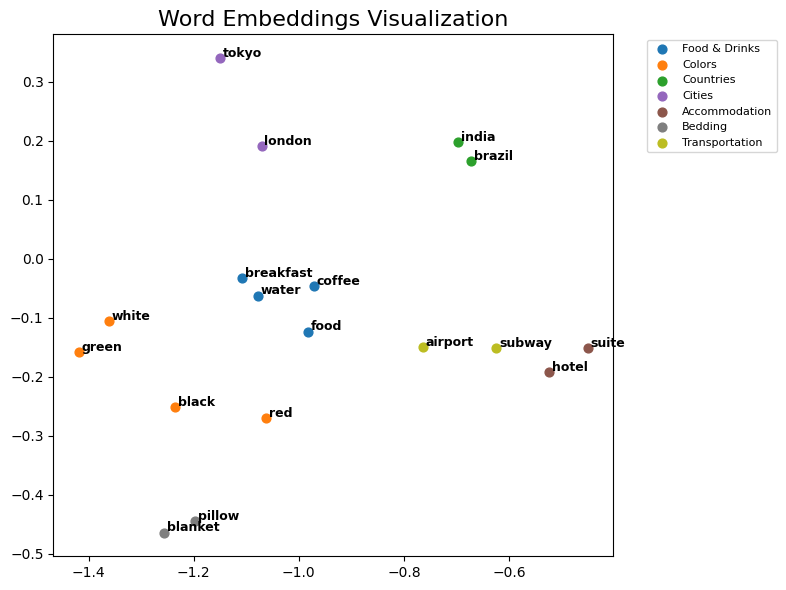

In [15]:
# Create the plot
plt.figure(figsize=(8, 6))

# Define a color map for categories
color_map = plt.colormaps['tab10']

for i, (category, words) in enumerate(categories.items()):
    color = color_map(i / len(categories))
    for word in words:
        if word in df_2d.index:
            x, y = df_2d.loc[word]
            plt.scatter(x, y, c=[color], label=category if word == words[0] else "", s=40)
            plt.annotate(word, (x, y), xytext=(2, 1), textcoords='offset points', fontsize=9, fontweight='bold')

plt.title("Word Embeddings Visualization", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

In the plot above, we can see that words that are related to each other are close to each other in the embedding space, which is good.


---------

## **Clustering - Bonus!**

### <u>Elbow Method:</u>

In [81]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [82]:
# Normalize the embeddings
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(embeddings)

We want to find the optimal number of clusters, using the elbow method:

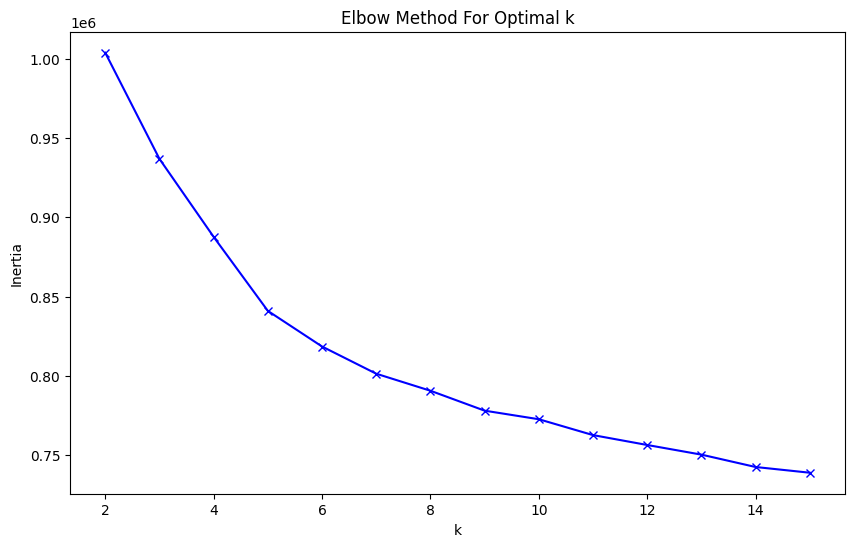

In [ ]:
inertias = []
k_range = range(2, 16)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(normalized_embeddings)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

It looks like the elbow is at k=5, which would be a good number of clusters.


### <u>K-means Clustering:</u>


In [55]:
# Perform K-means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(normalized_embeddings)

# Add cluster labels to the 2D embeddings dataframe
df_2d['Cluster'] = cluster_labels

# Calculate centroids
centroids = kmeans.cluster_centers_

### <u>Clusters Analysis:</u>


In [35]:
from scipy.spatial.distance import cdist

We want to find labels for the clusters, using the closest words to the centroids. But we want the words to be important, so we will also take into account their frequency in the dataset.


In [45]:
# Function to get the most frequent word from a list using the existing freq_voc
def get_frequent_word(word_list: List[str], top_n: int = 5) -> List[Tuple[str, int]]:
    freq_words = sorted([(w, freq_voc.get(w, 0)) for w in word_list if w in freq_voc],
                        key=lambda x: x[1], reverse=True)
    return freq_words[:top_n] if freq_words else [('', 0)]

# Find representative words for each cluster
representative_words = []
n_words_to_check = 100  # Number of closest words to check for each centroid

for i in range(n_clusters):
    cluster_points = normalized_embeddings[cluster_labels == i]
    cluster_words = embeddings.index[cluster_labels == i].tolist()

    # Calculate distances from centroid to all points in the cluster
    distances = cdist([centroids[i]], cluster_points)[0]

    # Sort words by distance from centroid
    sorted_indices = np.argsort(distances)
    sorted_words = [cluster_words[j] for j in sorted_indices[:n_words_to_check]]

    # Get the most frequent words from this cluster
    freq_words = get_frequent_word(sorted_words, top_n=5)
    representative_words.append(freq_words)

# Print representative words for each cluster
for i, words in enumerate(representative_words):
    print(f"Cluster {i}: {', '.join([f'{w}({c})' for w, c in words])}")

Cluster 0: and(428714), for(160969), but(106921), that(86980), so(50773)
Cluster 1: purtroppo(184), poteva(89), pare(32), granch(29), precedente(27)
Cluster 2: om(943), frsta(53), trevliga(53), sknt(32), roligt(27)
Cluster 3: mme(936), aussi(382), meme(178), intressant(57), ncessaire(53)
Cluster 4: porque(365), algo(330), falta(128), pedir(86), cierto(78)


In order to capture the meaning of each cluster, we will take 50 random words from each cluster.
Then we will try to identify the meaning of each cluster by looking at the words in it.

We repeated this process 3 times, to be more confident in our results.


In [56]:
for cluster in range(n_clusters):
    cluster_words = df_2d[df_2d['Cluster'] == cluster].index.tolist()
    random_words = np.random.choice(cluster_words, size=min(50, len(cluster_words)), replace=False)
    print(f"Cluster {cluster}: {', '.join(random_words)}")

Cluster 0: ambassador, williams, sum, katrina, tolerate, leisure, concerned, crawl, missed, abut, ranch, exhale, appearance, stamped, quarters, label, exhibit, busy, environmentally, embarrassment, displaced, regretted, nutshell, kitschy, astonishing, afterwards, faster, evita, excused, downgraded, livid, settee, breaks, outskirts, stage, dallas, twice, finishing, omlette, encourages, penalty, frying, queuing, hisher, nasa, unsuccessfully, exudes, whod, documentation, floored
Cluster 1: puoi, personalmente, rinfrescata, cucinotto, alcuni, turistico, oppure, trovata, ridotte, tecnico, corrente, avviso, accesso, vai, rapidi, privati, offerto, clientela, gentilmente, febbraio, prossima, vivibili, senza, accade, allinterno, ha, sarete, ottimo, meta, quello, previsto, restauro, parlare, pasti, consumare, cerano, terreno, massima, posizionato, allaltezza, italia, evitatelo, sentire, prenotazioni, termosifone, darci, aiutare, starci, laffaccio, centro
Cluster 2: zou, luktade, restaurangen, kl

Based on the words in each cluster (and thanks to ChatGPT!), we can see that the clusters are roughly seperated based on... **their language!**

We've found that the clusters are seperated based on the language of the reviews, which is quite interesting. And they are just words related to hotels/traveling, but in different languages.

<u>Conclusion:</u>

* **<u>Cluster 0: English.</u>** For example: "street", "view".
* **<u>Cluster 1: Italian.</u>** For example: "vacanza" (vacation), "pulite" (clean).
* **<u>Cluster 2: Scandinavian languages (Danish/Swedish/Norwegian).</u>** For example: "badevrelset" (bathroom), "stad" (city).
* **<u>Cluster 3: French.</u>** For example: "voyageurs" (travelers), "chambre" (room).
* **<u>Cluster 4: Spanish.</u>** For example: "habitacion" (room), "horario" (schedule).

### <u>Clustering Visualization:</u>

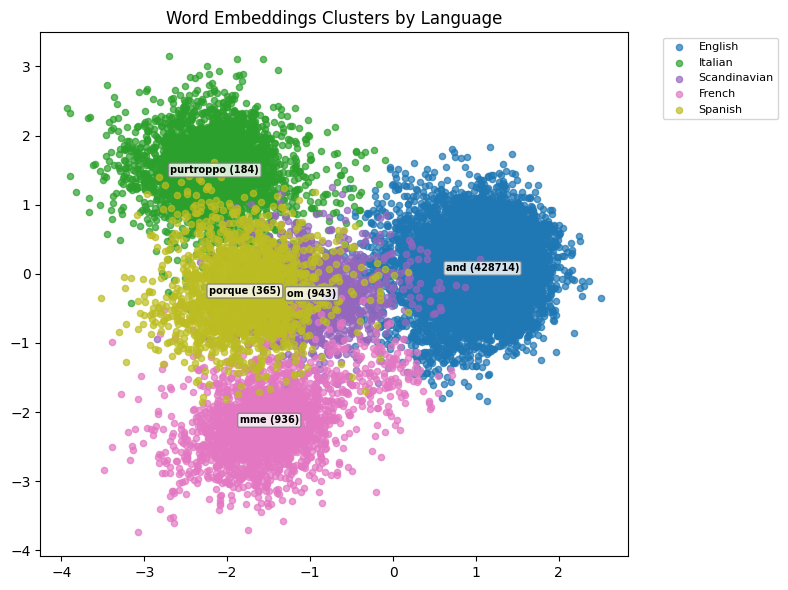

In [60]:
# Visualize the clusters
plt.figure(figsize=(8, 6))
color_map = plt.colormaps['tab10']

# Define language labels
language_labels = ['English', 'Italian', 'Scandinavian', 'French', 'Spanish']

for cluster in range(n_clusters):
    cluster_points = df_2d[df_2d['Cluster'] == cluster]
    plt.scatter(cluster_points['x'], cluster_points['y'],
                c=[color_map(cluster / n_clusters)],
                label=language_labels[cluster],
                alpha=0.7,
                s=20)

    # Calculate centroid of the cluster
    centroid_x = cluster_points['x'].mean()
    centroid_y = cluster_points['y'].mean()

    # Annotate with the most frequent word at the cluster centroid
    if representative_words[cluster][0][0]:  # Check if we have a word
        word, freq = representative_words[cluster][0]
        plt.annotate(f"{word} ({freq})", (centroid_x, centroid_y),
                     xytext=(0, 0), textcoords='offset points',
                     fontsize=7,
                     fontweight='bold',
                     ha='center', va='center',
                     bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.8))

plt.title("Word Embeddings Clusters by Language", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

<u>Translations of Important Words:</u>

* 'purtroppo' (Italian) = unfortunately.
* 'om' (Scandinavian) = about/if.
* 'mme' (French) = ma'am/madam.
* 'porque' (Spanish) = because/why.

--------

**The End!**